AHP Criteria Weights: {'AQI_Impact': 0.627, 'Species_Importance': 0.28, 'Tree_Density': 0.094}
Consistency Ratio: 0.087

Recommended Trees for Removal:
Species IDs: [963.0, 2678.0, 5745.0]
Location: (43.0853, -1.24129)

Species IDs: [10600.0, 11176.0, 963.0]
Location: (43.03547, -1.11561)

Species IDs: [7760.0, 8428.0, 1495.0, 5542.0, 2025.0, 8705.0, 976.0, 10247.0, 963.0]
Location: (42.95968, -0.64592)

Species IDs: [6989.0, 10600.0, 5071.0, 963.0, 1888.0, 1495.0, 981.0]
Location: (43.09824, -1.38937)

Species IDs: [2621.0, 1715.0, 8988.0]
Location: (42.61675, 2.124917)

Species IDs: [10600.0, 963.0]
Location: (43.0542, -1.09221)

Species IDs: [10600.0, 963.0, 53.0, 1495.0]
Location: (43.05498, -1.06773)

Species IDs: [4492.0, 10218.0, 4492.0]
Location: (42.5696, 2.0191533333333336)

Species IDs: [9826.0, 2013.0, 4492.0]
Location: (42.545, 2.01196)

Species IDs: [5173.0, 2885.0, 7862.0, 4238.0, 5542.0, 1539.0, 1276.0]
Location: (43.77191, 6.8072)

Species IDs: [4842.0, 4842.0, 6905.0,

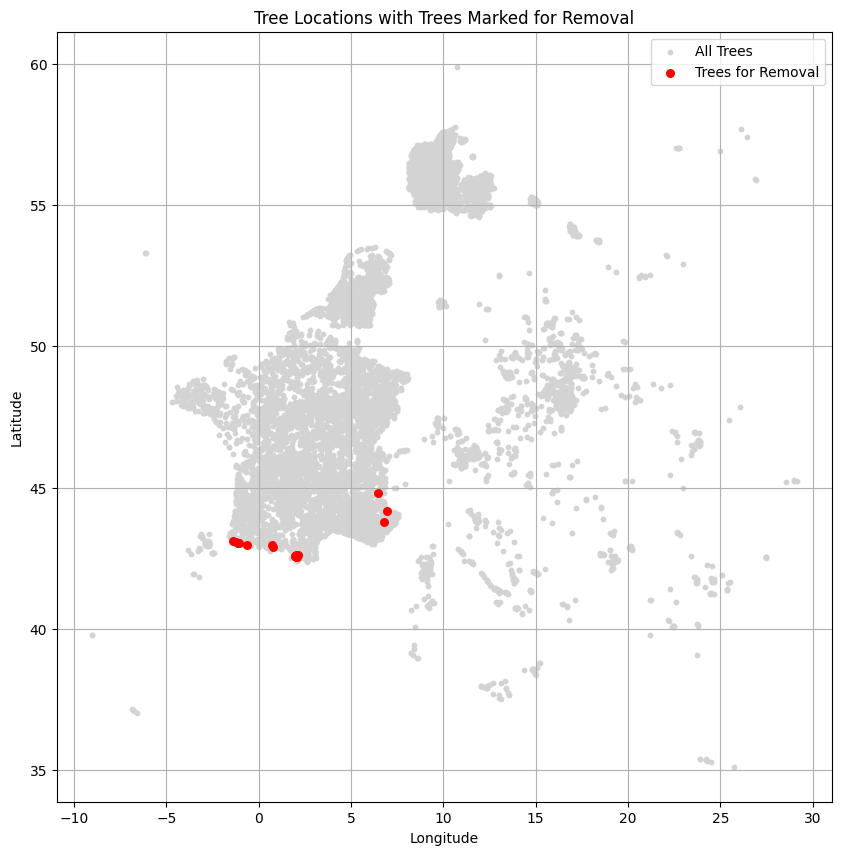

In [6]:
import pandas as pd
import numpy as np
from ahpy import Compare
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def load_data():
    merged_data = pd.read_csv('cluster_with_pollution_data.csv')
    merged_data['coordinates_lon'] = merged_data['coordinates_lon'].apply(eval)
    merged_data['coordinates_lat'] = merged_data['coordinates_lat'].apply(eval)
    merged_data['speciesId'] = merged_data['speciesId'].apply(eval)
    return merged_data

def calculate_criteria(df):
    df['AQI_Impact'] = 0.4 * df['AQI'] + 0.2 * df['CO'] + 0.2 * df['NO2'] + 0.2 * df['PM2.5']
    df['Species_Importance'] = df['speciesId'].apply(lambda x: len(set(x)))
    df['Tree_Density'] = df['coordinates_lon'].apply(len)
    df['Tree_Count'] = df['speciesId'].apply(len)
    return df

def calculate_ahp_weights():
    criteria = {
        ('AQI_Impact', 'Species_Importance'): 3,
        ('AQI_Impact', 'Tree_Density'): 5,
        ('Species_Importance', 'Tree_Density'): 4,
    }
    comparison = Compare('Criteria', criteria, precision=3)
    weights = comparison.target_weights
    print("AHP Criteria Weights:", weights)
    print("Consistency Ratio:", comparison.consistency_ratio)
    return weights

def topsis_ranking(df, weights, num_trees_to_remove):
    aqi_preservation_threshold = df['AQI_Impact'].quantile(0.7)
    species_importance_threshold = df['Species_Importance'].quantile(0.7)

    df['Preserve'] = (df['AQI_Impact'] >= aqi_preservation_threshold) | \
                     (df['Species_Importance'] >= species_importance_threshold)
    removal_candidates = df[~df['Preserve']].copy()

    scaler = MinMaxScaler()
    criteria_data = removal_candidates[['AQI_Impact', 'Species_Importance', 'Tree_Density']]
    normalized_data = scaler.fit_transform(criteria_data)
    weighted_data = normalized_data * np.array(list(weights.values()))

    ideal_solution = np.max(weighted_data, axis=0)
    negative_ideal_solution = np.min(weighted_data, axis=0)

    dist_to_ideal = np.sqrt(np.sum((weighted_data - ideal_solution) ** 2, axis=1))
    dist_to_negative_ideal = np.sqrt(np.sum((weighted_data - negative_ideal_solution) ** 2, axis=1))

    topsis_score = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)
    removal_candidates['TOPSIS_Score'] = topsis_score
    removal_candidates = removal_candidates.sort_values(by='TOPSIS_Score', ascending=True)

    total_trees = 0
    selected_clusters = []

    for _, row in removal_candidates.iterrows():
        total_trees += row['Tree_Count']
        selected_clusters.append(row)
        if total_trees >= num_trees_to_remove:
            break

    selected_clusters_df = pd.DataFrame(selected_clusters)

    if total_trees > num_trees_to_remove:
        excess_trees = total_trees - num_trees_to_remove
        last_cluster_index = selected_clusters_df.index[-1]
        last_cluster = selected_clusters_df.loc[last_cluster_index]
        limited_species = last_cluster['speciesId'][:-excess_trees]
        selected_clusters_df.at[last_cluster_index, 'speciesId'] = limited_species

    selected_clusters_df['Tree_Count'] = selected_clusters_df['speciesId'].apply(len)

    return selected_clusters_df

def plot_clusters(df, selected_clusters):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['average_lon'], df['average_lat'], c='lightgray', s=10, label='All Trees')
    plt.scatter(selected_clusters['average_lon'], selected_clusters['average_lat'], c='red', s=30, label='Trees for Removal')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Tree Locations with Trees Marked for Removal")
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    merged_data = load_data()
    merged_data = calculate_criteria(merged_data)
    weights = calculate_ahp_weights()

    try:
        num_trees_to_remove = int(input("Enter the number of trees to remove: "))
    except ValueError:
        print("Invalid input. Please enter a numerical value.")
        return

    if all(col in merged_data.columns for col in ['AQI_Impact', 'Species_Importance', 'Tree_Density', 'Tree_Count']):
        selected_clusters = topsis_ranking(merged_data, weights, num_trees_to_remove)
        
        print("\nRecommended Trees for Removal:")
        for idx, row in selected_clusters.iterrows():
            print(f"Species IDs: {row['speciesId']}")
            print(f"Location: ({row['average_lat']}, {row['average_lon']})\n")
        
        plot_clusters(merged_data, selected_clusters)
    else:
        print("Error: Ensure that all necessary criteria columns are present in 'cluster_with_pollution_data.csv'.")

if __name__ == "__main__":
    main()